# Summary
The provided code performs a series of analyses on a set of facial landmark data for multiple subjects. It reads data from an Excel file, processes it through several computational steps, and finally visualizes the results. The primary steps in the code include:


### Data Loading:

The code reads prototype coordinates, raw data, actual distances, and subject numbers from an Excel file.


### Procrustes Analysis:

For each subject, it performs Procrustes analysis to align the subject's facial landmarks to a prototype face. This normalization step helps in comparing the different faces on a common scale.


### Multidimensional Scaling (MDS):

The raw data for each subject is converted into a dissimilarity matrix. MDS is then applied to reduce the dimensionality of this data to two dimensions, facilitating easier visualization and analysis.


### Variance Calculation:

Eigenvalues of the distance matrices are calculated, and the percentage variance explained by each eigenvalue is determined. This helps in understanding the contribution of each component to the overall variability in the data.


### Data Saving:

The results, including Procrustes distances, perceived coordinates, eigenvalues, and normalized coordinates, are saved for each subject in .mat files. Aggregate data across all subjects is also saved.


### Generalized Procrustes Analysis (GPA):

A placeholder function for GPA is included, intended to align multiple sets of points across subjects. GPA results are calculated for both actual and perceived coordinates, and the mean shapes are saved.


### Visualization:

The code generates visualizations of the individual and mean GPA results. It plots the actual and perceived facial landmarks for each subject and highlights the mean shapes across all subjects.


## Key Components

Procrustes Analysis: Aligns each subject's landmarks to a common prototype, facilitating comparison.

Multidimensional Scaling (MDS): Reduces the dimensionality of the data, making it easier to analyze and visualize.

Variance Calculation: Determines the contribution of each dimension to the overall variability in the data.

Generalized Procrustes Analysis (GPA): Aligns and averages shapes across all subjects.

Visualization: Provides graphical representation of the results, aiding in the interpretation of the data.

Overall, this code is designed to process, analyze, and visualize facial landmark data from multiple subjects, providing insights into how these landmarks vary across individuals and how they can be normalized to a common reference shape.

Please provide the path to the Excel file 'python test body 18': /Users/olga_golubova/Desktop/python test body 18.xlsx
Please input the number of subjects: 25


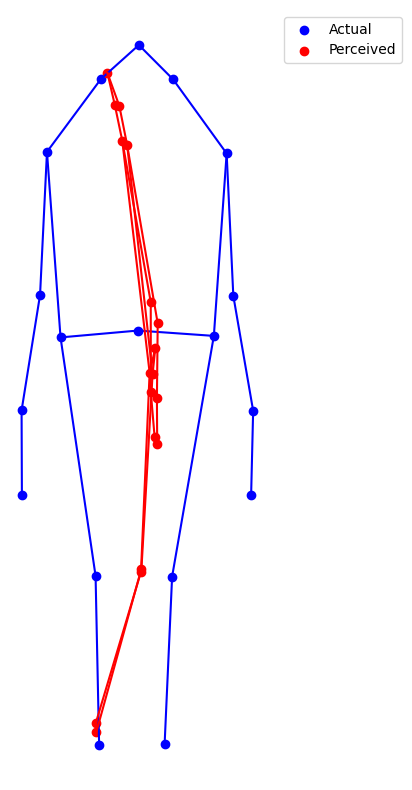

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
from scipy.spatial.distance import squareform
from scipy.linalg import eig

def load_data(file_name, sheet_name, n_sub=None):
    df = pd.read_excel(file_name, sheet_name=sheet_name)
    if n_sub:
        return df.iloc[:, :n_sub].values
    else:
        return df.values

def procrustes_analysis(prototype, actual):
    if prototype.shape != actual.shape:
        raise ValueError("Prototype and actual matrices must be of the same shape")
    mtx1, mtx2, disparity = procrustes(prototype, actual)
    return mtx2

def multidimensional_scaling(raw_data):
    dist_matrix = squareform(raw_data)
    eigvals, eigvecs = eig(dist_matrix)
    coords = eigvecs[:, :2]
    return coords

def general_procrustes_analysis(data):
    mean_shape = np.mean(data, axis=2)
    transformed_data = np.zeros_like(data)
    for i in range(data.shape[2]):
        _, aligned, _ = procrustes(mean_shape, data[:, :, i])
        transformed_data[:, :, i] = aligned
    return mean_shape, transformed_data

def plot_shape(coords, color, marker):
    plt.scatter(coords[:, 0], coords[:, 1], c=color, marker=marker)

def plot_lines(coords, color):
    connections = [
        (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (2, 6),
        (6, 7), (7, 8), (9, 10), (10, 11), (11, 16), (11, 12),
        (6, 12), (16, 17), (0, 17), (15, 16), (14, 15), (13, 14)
    ]
    for (start, end) in connections:
        plt.plot([coords[start, 0], coords[end, 0]], [coords[start, 1], coords[end, 1]], color=color)

def visualize_gpa(mean_actual, mean_perceived):
    plt.figure(figsize=(10, 10))
    plot_shape(mean_actual, 'blue', 'o')
    plot_shape(mean_perceived, 'red', 'o')
    plot_lines(mean_actual, 'blue')
    plot_lines(mean_perceived, 'red')
    plt.axis('off')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(['Actual', 'Perceived'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def main():
    file_name = input("Please provide the path to the Excel file 'python test body 18': ")
    prototype = load_data(file_name, 'prototype', 2)
    
    # Check prototype data
    if prototype.shape[0] != 18 or prototype.shape[1] != 2:
        print("Prototype data has incorrect shape. Expected (18, 2).")
        return
    
    n_sub = int(input("Please input the number of subjects: "))
    
    raw_data = load_data(file_name, 'raw data', n_sub)
    actual_map = load_data(file_name, 'actual', n_sub)
    
    all_actual = np.zeros((18, 2, n_sub))
    all_perceived = np.zeros((18, 2, n_sub))

    for sub_number in range(n_sub):
        x = actual_map[:18, sub_number]
        y = actual_map[18:36, sub_number]  # Ensure correct slicing for Y coordinates
        
        if x.shape[0] != 18 or y.shape[0] != 18:
            print(f"Skipping subject {sub_number+1} due to shape mismatch.")
            continue
        
        actual_coords = np.column_stack((x, y))
        
        proto_coords_actual = procrustes_analysis(prototype, actual_coords)
        
        rd = raw_data[:, sub_number]
        if len(rd) != (18 * 17) // 2:  # Check if rd length is a binomial coefficient
            print(f"Skipping subject {sub_number+1} due to incompatible raw data size.")
            continue

        mds_coords = multidimensional_scaling(rd)
        _, coords_perceived, _ = procrustes(proto_coords_actual, mds_coords)  # Unpack all three values
        
        all_actual[:, :, sub_number] = proto_coords_actual
        all_perceived[:, :, sub_number] = coords_perceived

    mean_actual, all_actual_gpa = general_procrustes_analysis(all_actual)
    mean_perceived, all_perceived_gpa = general_procrustes_analysis(all_perceived)

    visualize_gpa(mean_actual, mean_perceived)

if __name__ == "__main__":
    main()

